In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=7
currency_pair = 'SEK=X'
numbers_in_currency = 'SEK'
share_name = 'BOL.ST'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

## (OPTIONAL) Time Filtering - Last 7 years daat

In [4]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2002-03-31,2406,2168,238,17,454,0,1417,3024,0,...,10906,0,0,4,2215,5140,8411,-196,-131,86
1,2002-06-30,2651,-2412,239,13,737,0,1399,3199,0,...,11095,0,0,13,2318,5285,8615,274,-99,86
2,2002-09-30,2196,-2026,180,22,303,0,1312,2651,0,...,10482,0,0,316,2065,5111,7972,-143,-94,86
3,2002-12-31,2304,-1990,314,80,768,0,1192,2845,0,...,10694,0,0,330,2038,5195,8104,562,-196,86
4,2003-03-31,2338,2074,264,130,798,0,1255,3120,0,...,10862,0,0,341,1881,5183,7925,174,-132,168


## Calculate date when quaterly reports could be available

In [5]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [6]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
83,2022-12-31,2023-02-11,273,23577,-19474,4103,2577,12159,3830,22278,...,3533,96376,10335,0,414,15832,10639,38065,7295,-3724
84,2023-03-31,2023-04-21,273,19962,-15872,4090,2541,13722,3721,25067,...,3517,102257,12361,0,427,17226,12301,41498,2871,-2918
85,2023-06-30,2023-07-21,273,18442,-16823,1619,521,3589,3200,25938,...,3619,97568,11654,0,2598,18891,11165,42376,449,-4219
86,2023-09-30,2023-10-21,273,19396,-16953,2443,1357,4219,3711,24137,...,3587,98032,10714,0,3776,18167,11723,42021,2392,-3590
87,2023-12-31,2024-02-11,273,20754,-18170,2585,1656,4978,3964,21987,...,3537,101957,10915,0,2962,18396,11462,38052,6471,-4804


## Pull historical average USD national currency rates and add to the dataframe

In [7]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

SEK=X: No price data found, symbol may be delisted (1d 2003-07-02 00:00:00 -> 2003-09-30 00:00:00)
/Users/zsolt.nagy/Desktop/projects/Economy/notebooks/value_investing/notebooks/utils.ipynb:68: RuntimeWarning: Mean of empty slice.
  "    return filtered"
/Users/zsolt.nagy/Desktop/projects/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
83,2022-12-31,2023-02-11,273,23577,-19474,4103,2577,12159,3830,22278,...,96376,10335,0,414,15832,10639,38065,7295,-3724,10.721097
84,2023-03-31,2023-04-21,273,19962,-15872,4090,2541,13722,3721,25067,...,102257,12361,0,427,17226,12301,41498,2871,-2918,10.432528
85,2023-06-30,2023-07-21,273,18442,-16823,1619,521,3589,3200,25938,...,97568,11654,0,2598,18891,11165,42376,449,-4219,10.518236
86,2023-09-30,2023-10-21,273,19396,-16953,2443,1357,4219,3711,24137,...,98032,10714,0,3776,18167,11723,42021,2392,-3590,10.805716
87,2023-12-31,2024-02-11,273,20754,-18170,2585,1656,4978,3964,21987,...,101957,10915,0,2962,18396,11462,38052,6471,-4804,10.657495


## Convert USD values related to IS, BS, CFS to national currency

In [8]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
83,2022-12-31,2023-02-11,273,23577,-19474,4103,2577,12159,3830,22278,...,96376,10335,0,414,15832,10639,38065,7295,-3724,10.721097
84,2023-03-31,2023-04-21,273,19962,-15872,4090,2541,13722,3721,25067,...,102257,12361,0,427,17226,12301,41498,2871,-2918,10.432528
85,2023-06-30,2023-07-21,273,18442,-16823,1619,521,3589,3200,25938,...,97568,11654,0,2598,18891,11165,42376,449,-4219,10.518236
86,2023-09-30,2023-10-21,273,19396,-16953,2443,1357,4219,3711,24137,...,98032,10714,0,3776,18167,11723,42021,2392,-3590,10.805716
87,2023-12-31,2024-02-11,273,20754,-18170,2585,1656,4978,3964,21987,...,101957,10915,0,2962,18396,11462,38052,6471,-4804,10.657495


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [9]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [10]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [11]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [12]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2002-04-22,18.283899,2002-03-31,2406.0,0.790698,29.011628,86.0,-260.0,-3.023256,454.0,...,0.228773,0.771227,inf,-inf,21.198238,-6.119972,0.098919,0.007066,0.006235,0.027255
1,2002-04-29,17.062162,2002-03-31,2406.0,0.790698,29.011628,86.0,-260.0,-3.023256,454.0,...,0.228773,0.771227,inf,-inf,21.198238,-6.119972,0.098919,0.007066,0.006235,0.027255
2,2002-05-06,16.851517,2002-03-31,2406.0,0.790698,29.011628,86.0,-260.0,-3.023256,454.0,...,0.228773,0.771227,inf,-inf,21.198238,-6.119972,0.098919,0.007066,0.006235,0.027255
3,2002-05-13,16.809389,2002-03-31,2406.0,0.790698,29.011628,86.0,-260.0,-3.023256,454.0,...,0.228773,0.771227,inf,-inf,21.198238,-6.119972,0.098919,0.007066,0.006235,0.027255
4,2002-05-20,16.472359,2002-03-31,2406.0,0.790698,29.011628,86.0,-260.0,-3.023256,454.0,...,0.228773,0.771227,inf,-inf,21.198238,-6.119972,0.098919,0.007066,0.006235,0.027255


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [13]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2002-04-22,18.283899,2002-03-31,2406.0,0.790698,29.011628,86.0,-260.0,-3.023256,454.0,...,-6.119972,0.098919,0.007066,0.006235,0.027255,23.123755,0.630227,0.163385,0.990172,-6.047751
1,2002-04-29,17.062162,2002-03-31,2406.0,0.790698,29.011628,86.0,-260.0,-3.023256,454.0,...,-6.119972,0.098919,0.007066,0.006235,0.027255,21.578617,0.588115,0.152467,0.979255,-5.643638
2,2002-05-06,16.851517,2002-03-31,2406.0,0.790698,29.011628,86.0,-260.0,-3.023256,454.0,...,-6.119972,0.098919,0.007066,0.006235,0.027255,21.312212,0.580854,0.150585,0.977372,-5.573963
3,2002-05-13,16.809389,2002-03-31,2406.0,0.790698,29.011628,86.0,-260.0,-3.023256,454.0,...,-6.119972,0.098919,0.007066,0.006235,0.027255,21.258933,0.579402,0.150209,0.976996,-5.560029
4,2002-05-20,16.472359,2002-03-31,2406.0,0.790698,29.011628,86.0,-260.0,-3.023256,454.0,...,-6.119972,0.098919,0.007066,0.006235,0.027255,20.832689,0.567785,0.147197,0.973984,-5.448549


# Calculate Dividend yield and currency-share price correlation

In [14]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

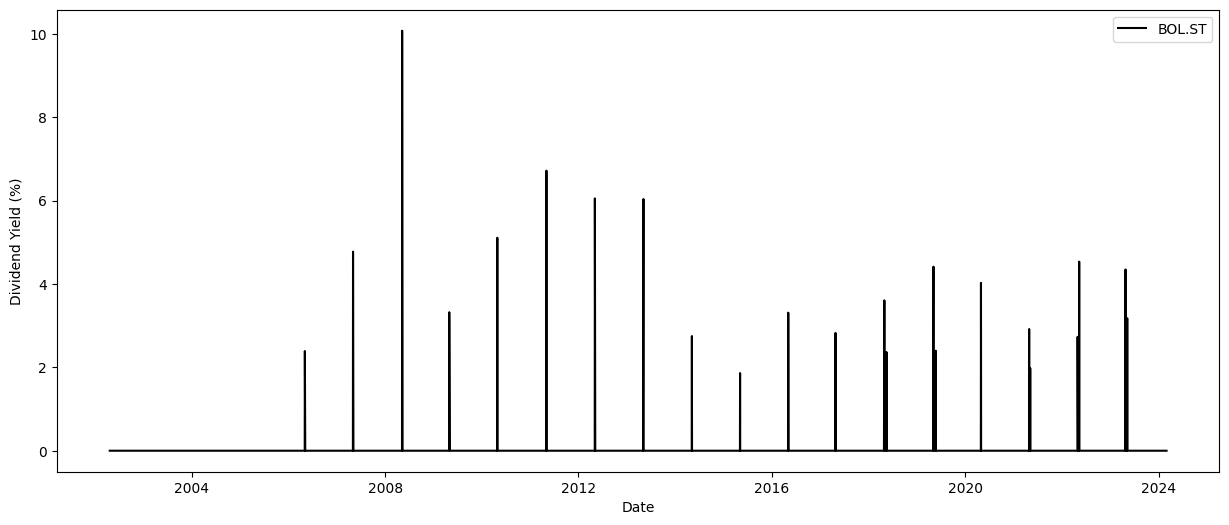

In [15]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.717221
share_price      1.000000
Name: share_price, dtype: float64


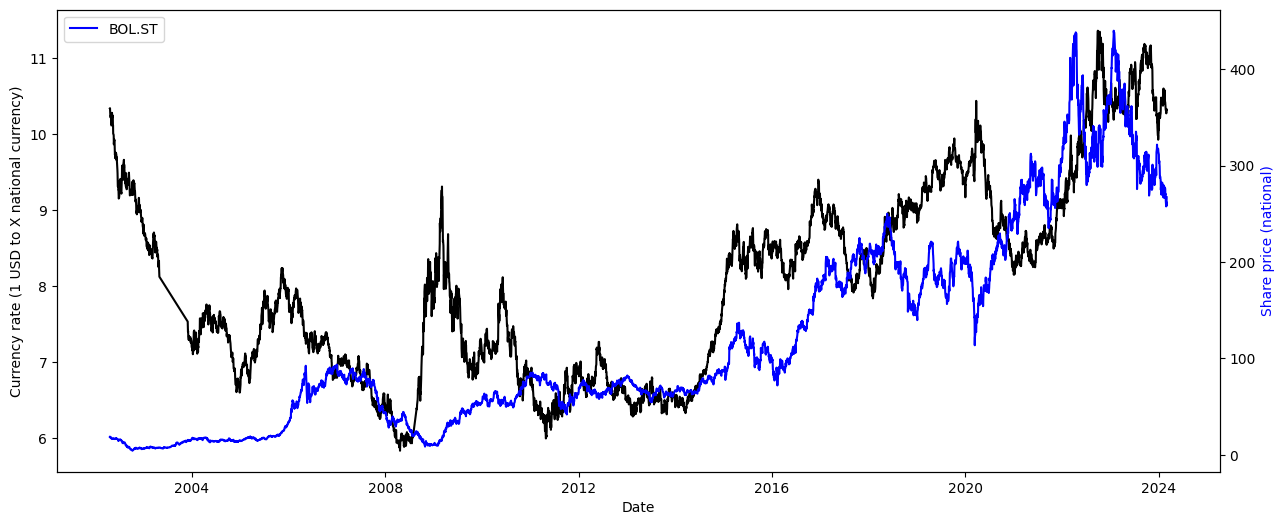

In [16]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

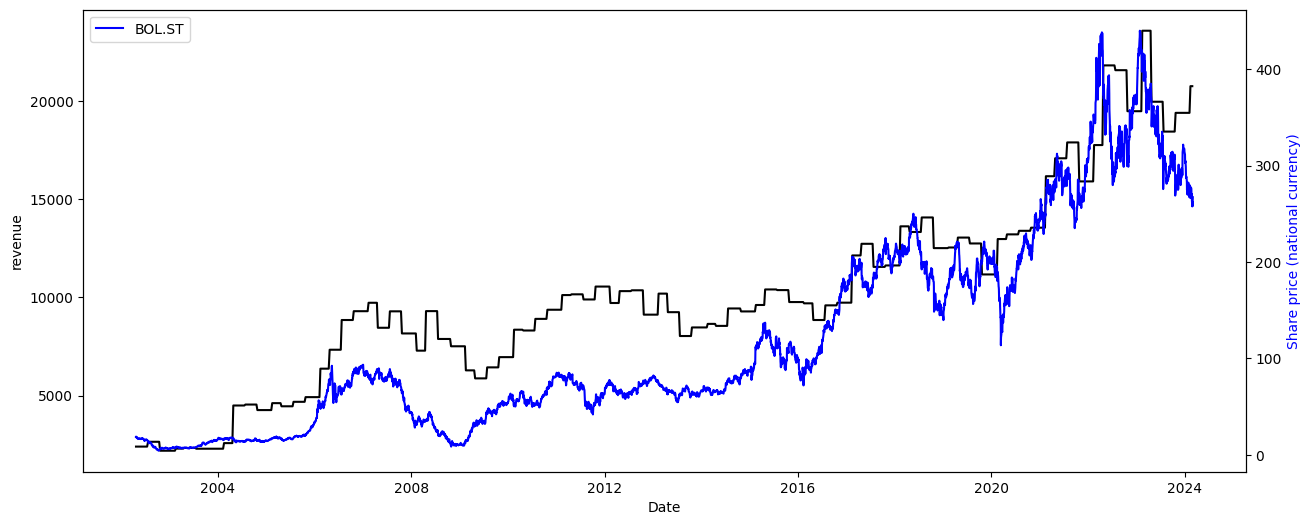

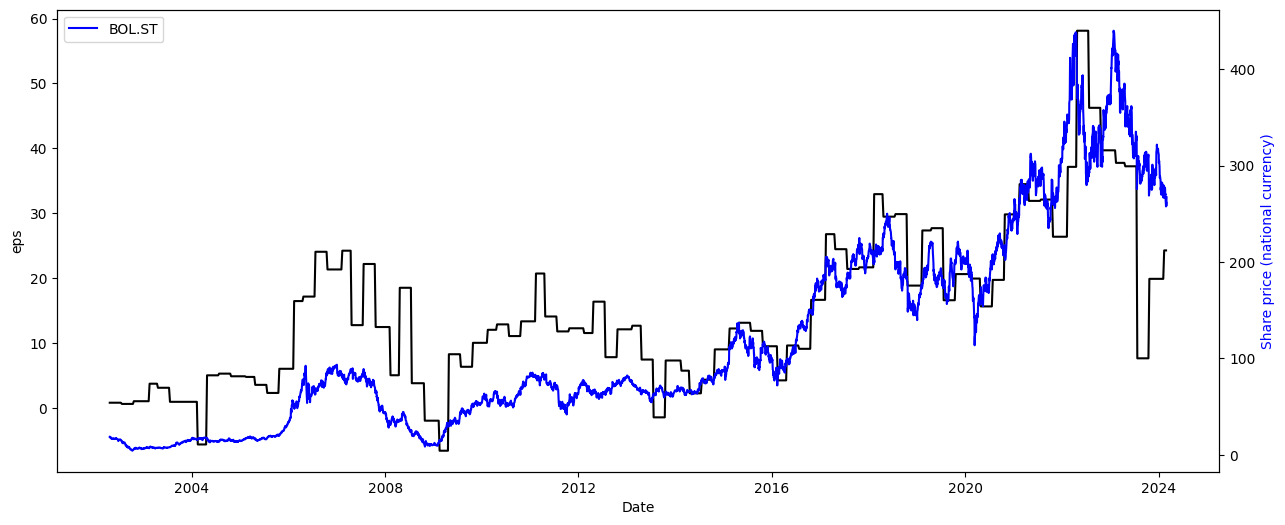

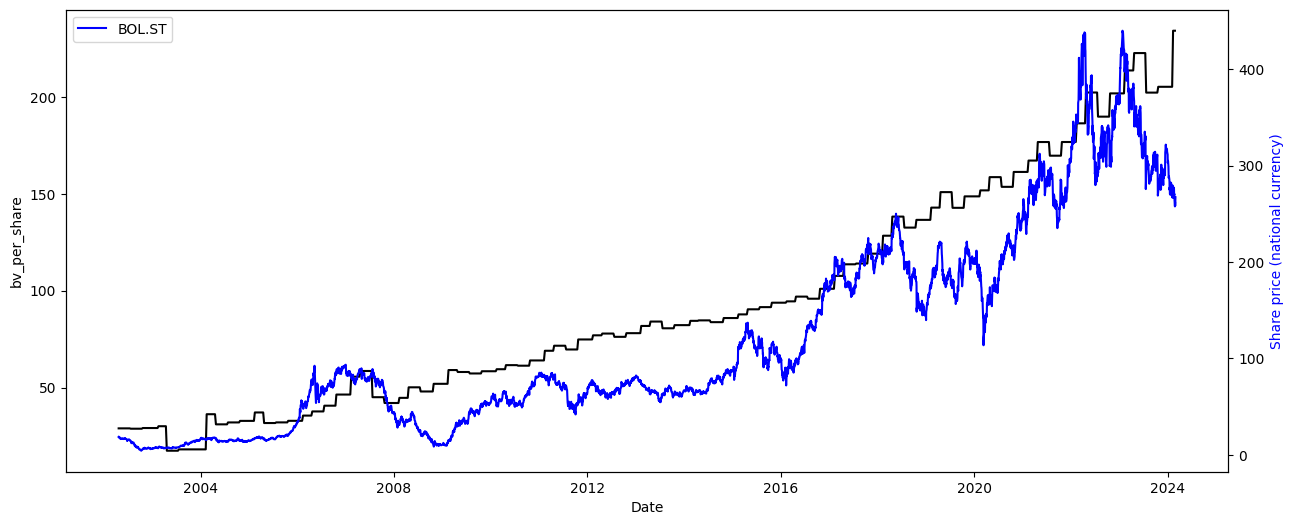

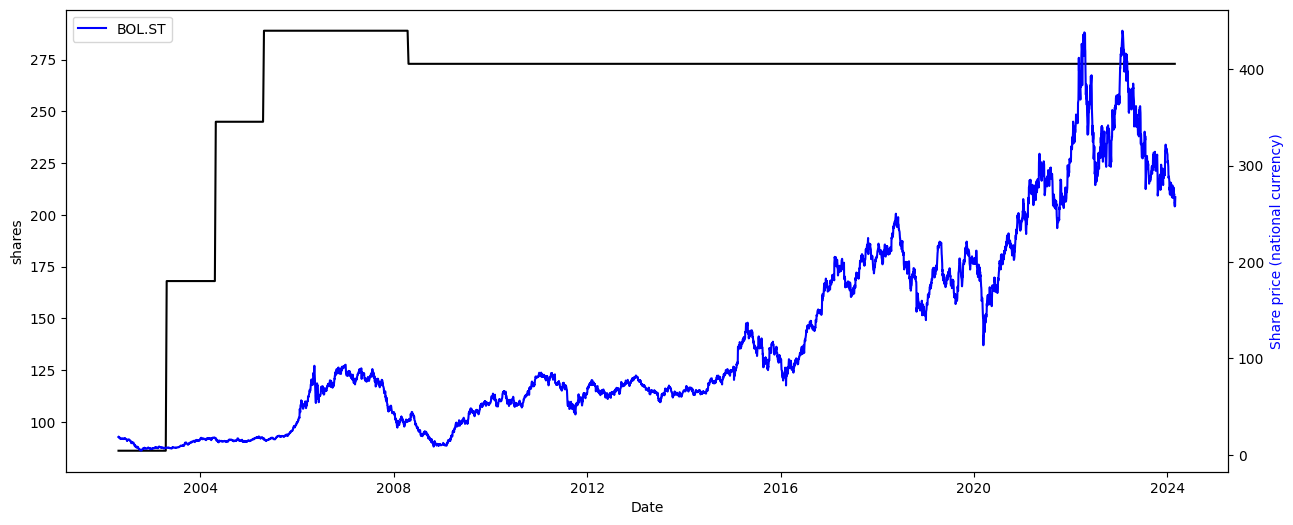

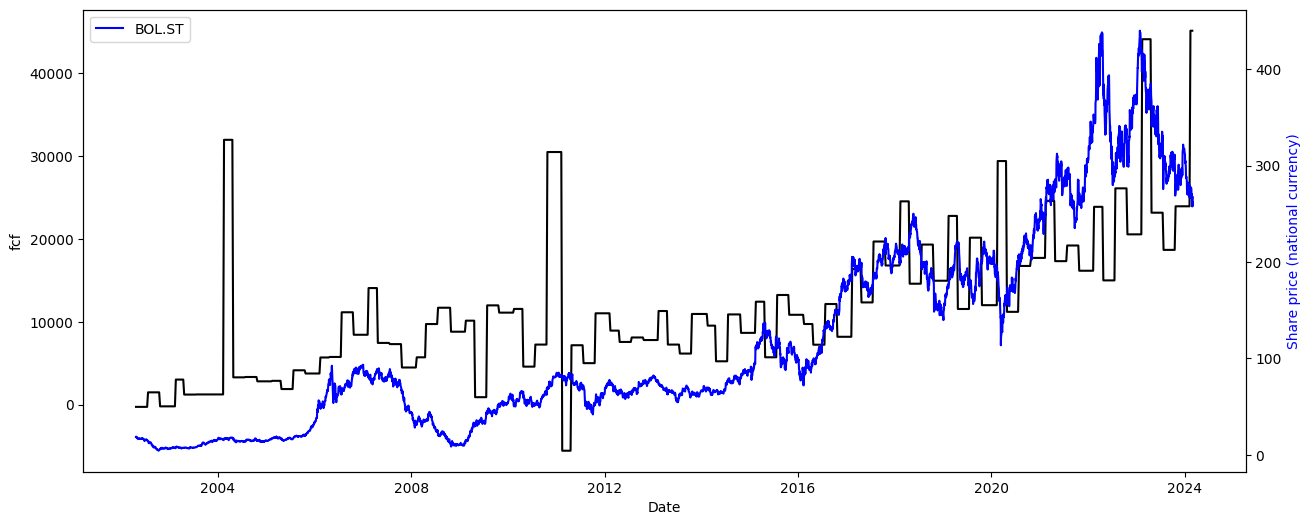

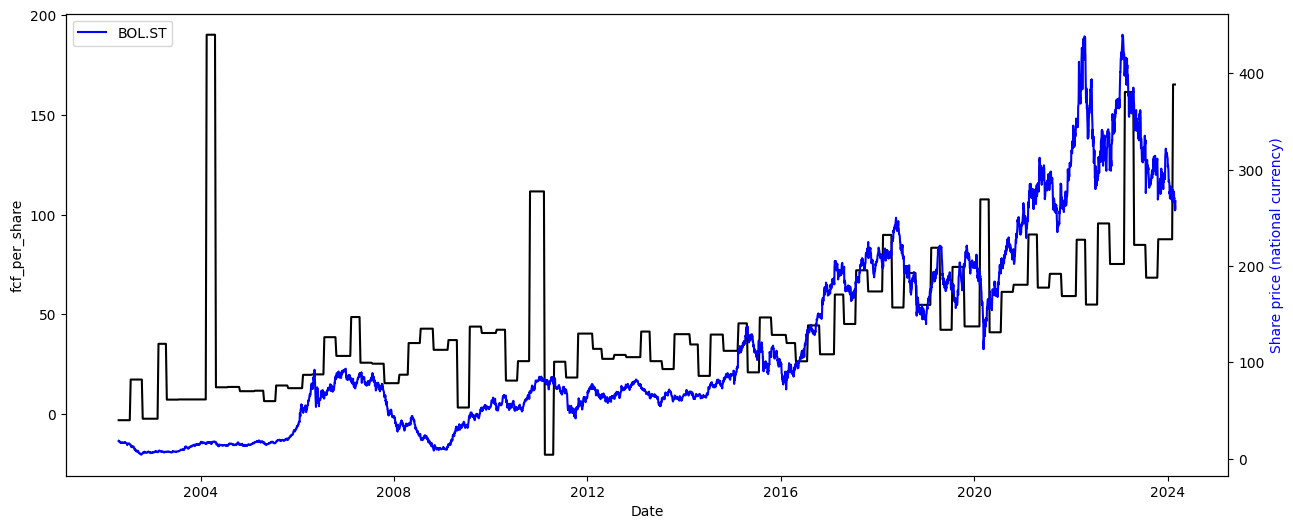

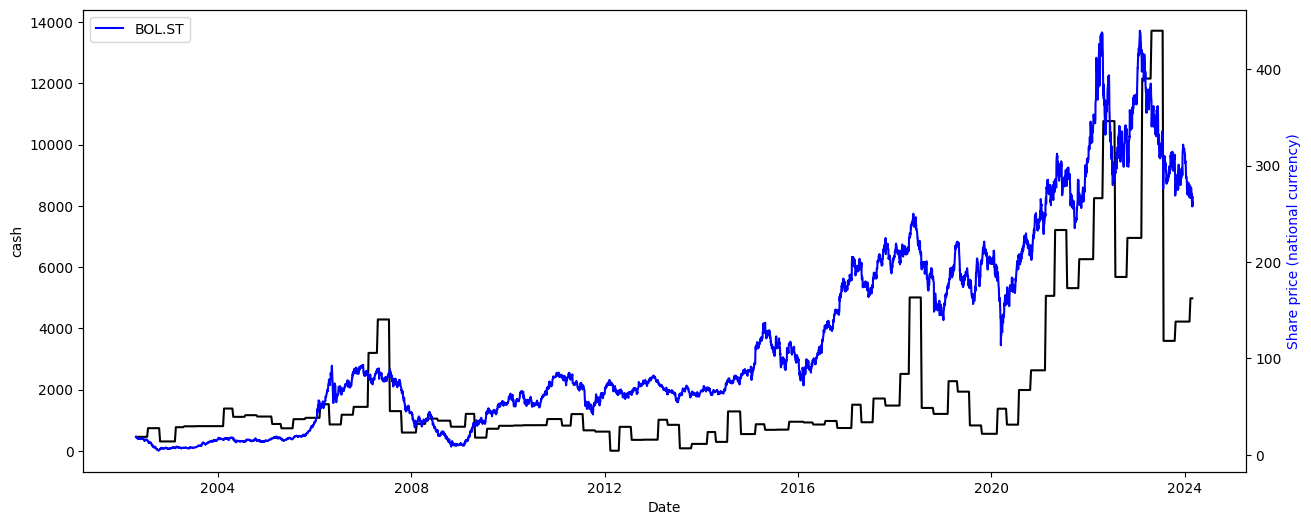

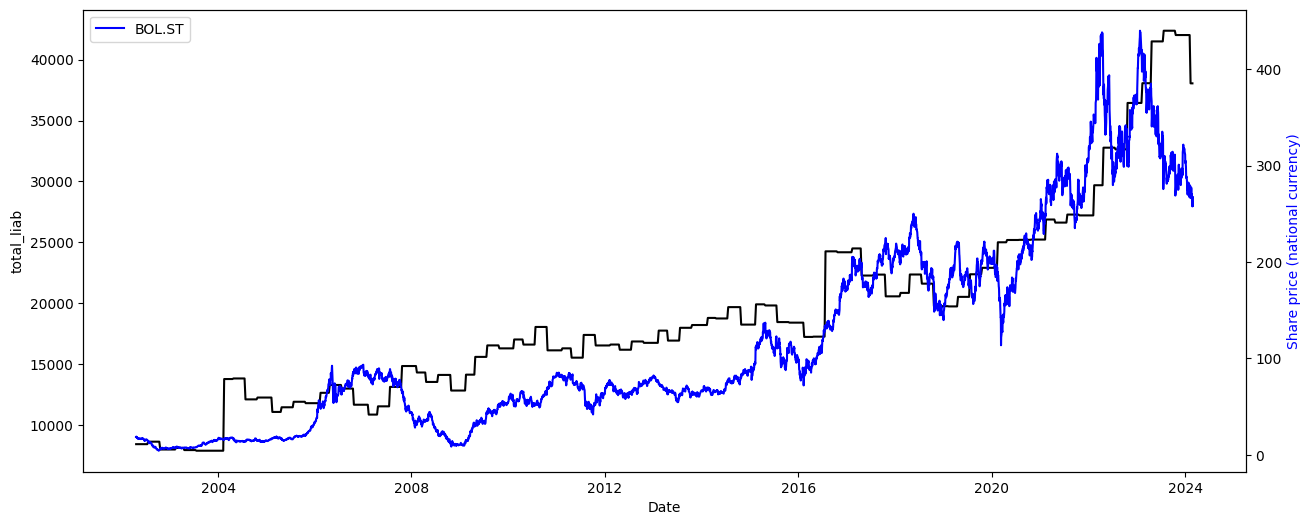

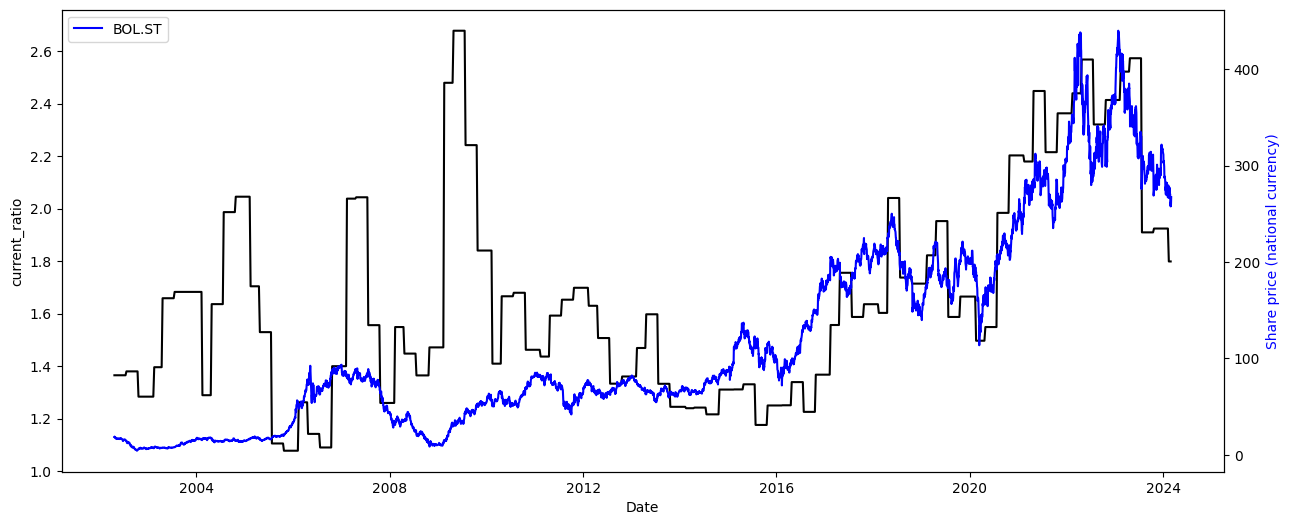

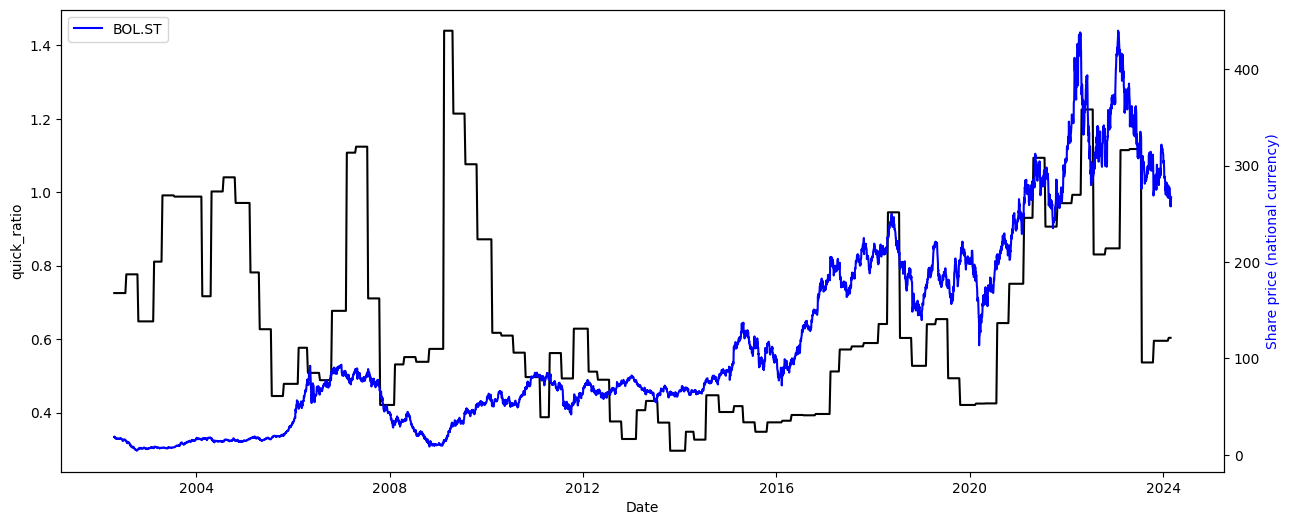

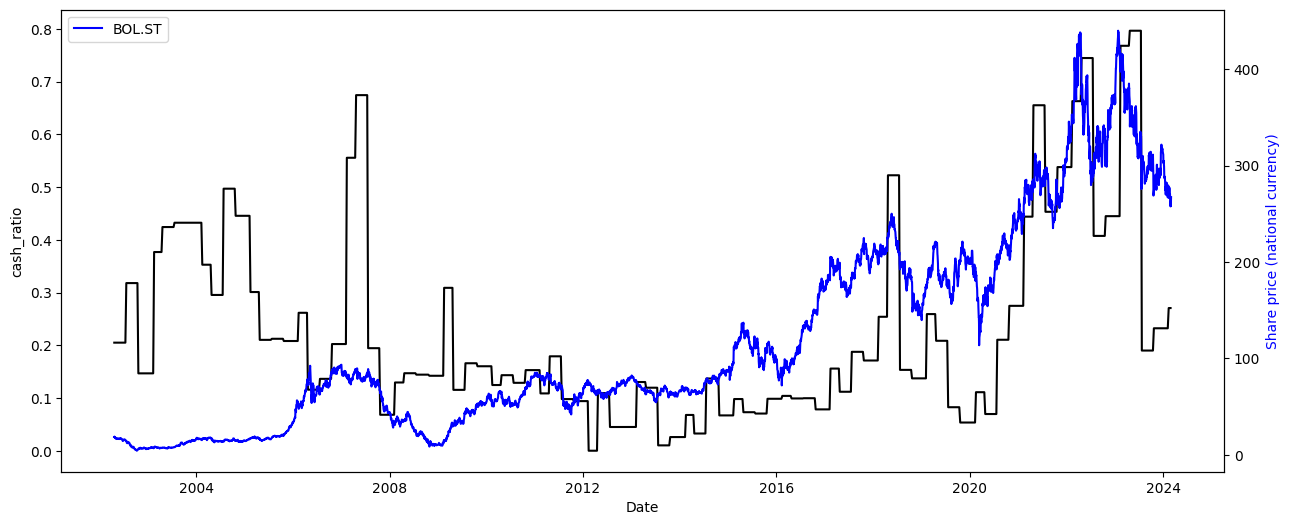

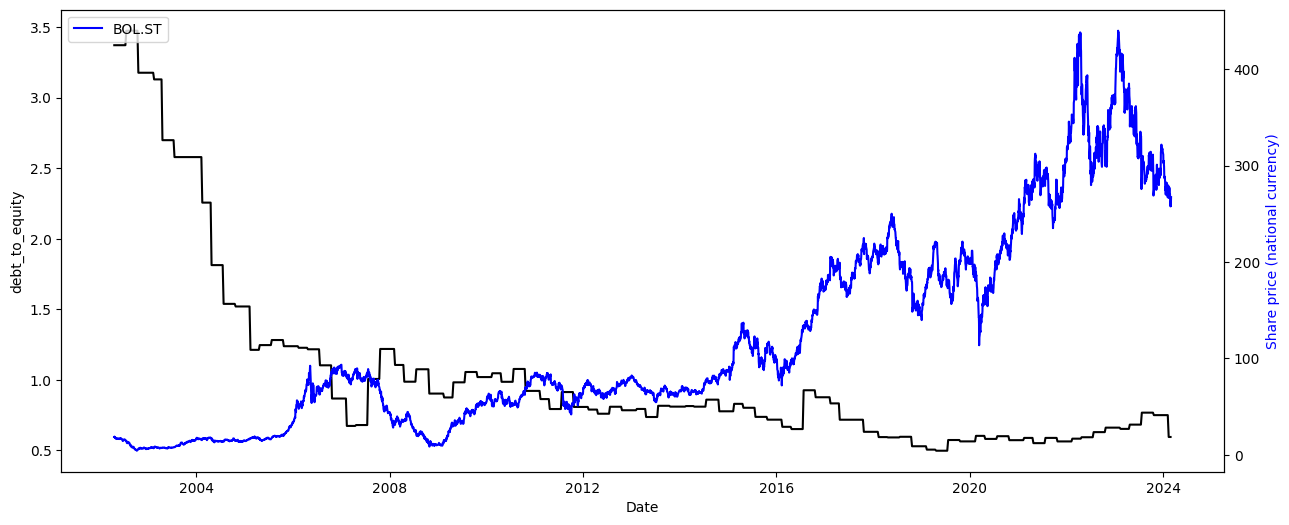

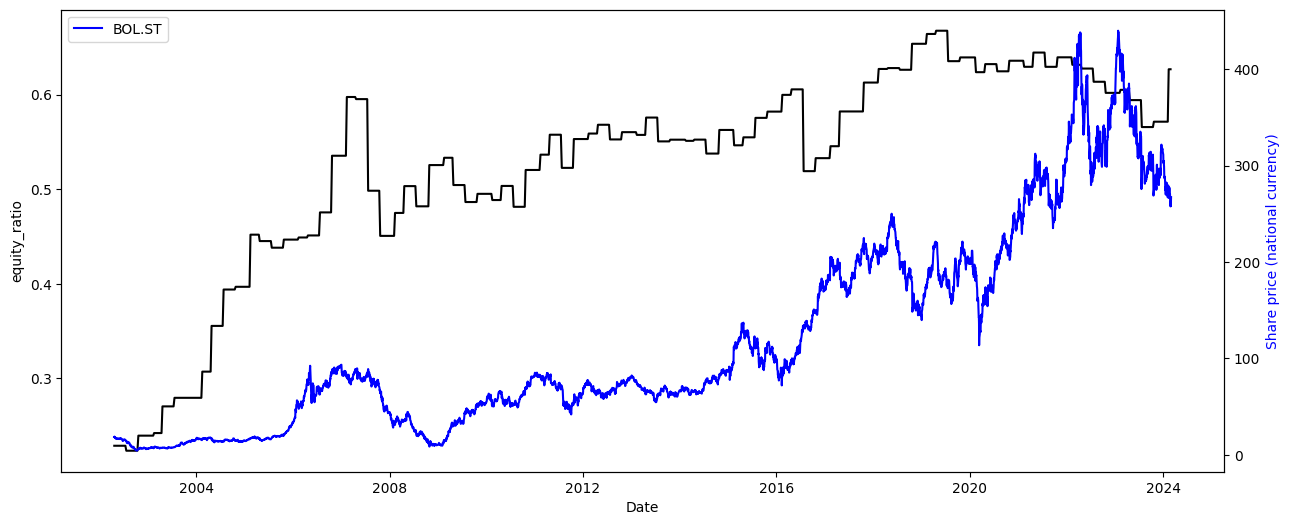

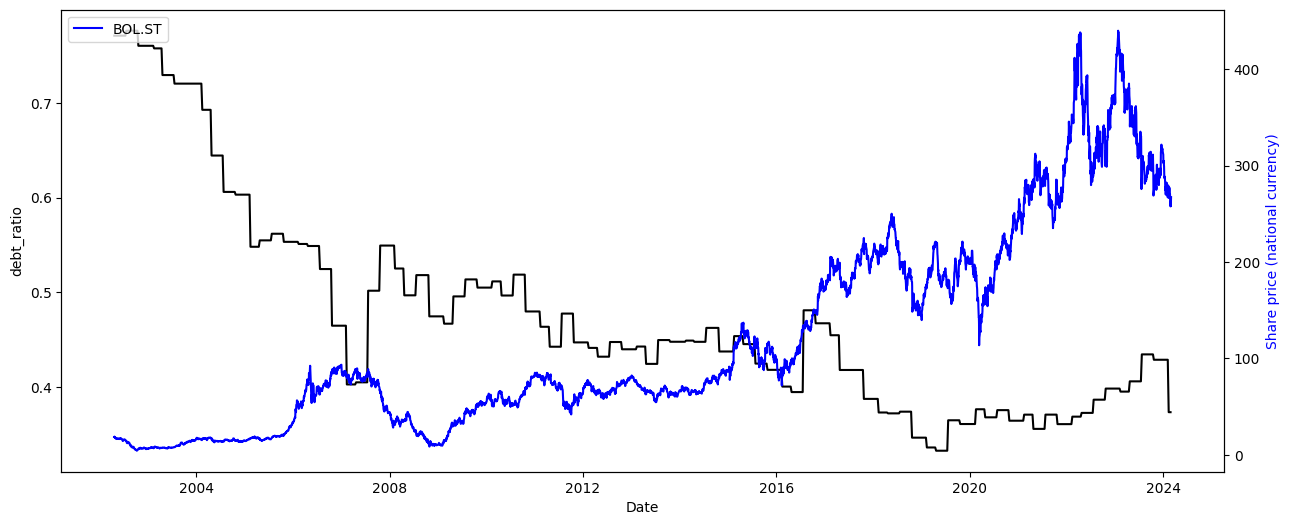

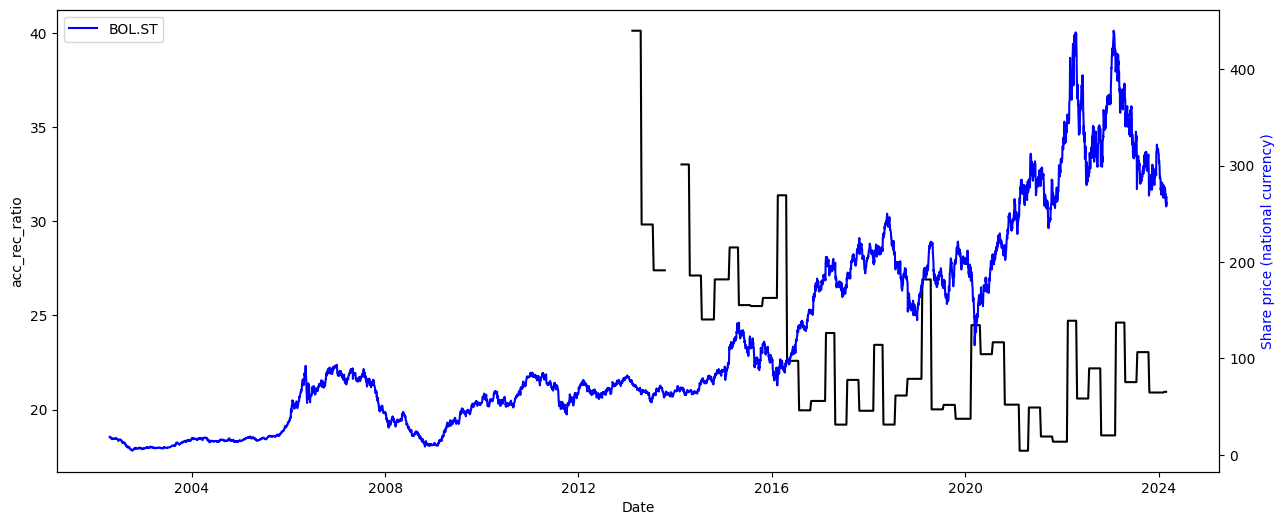

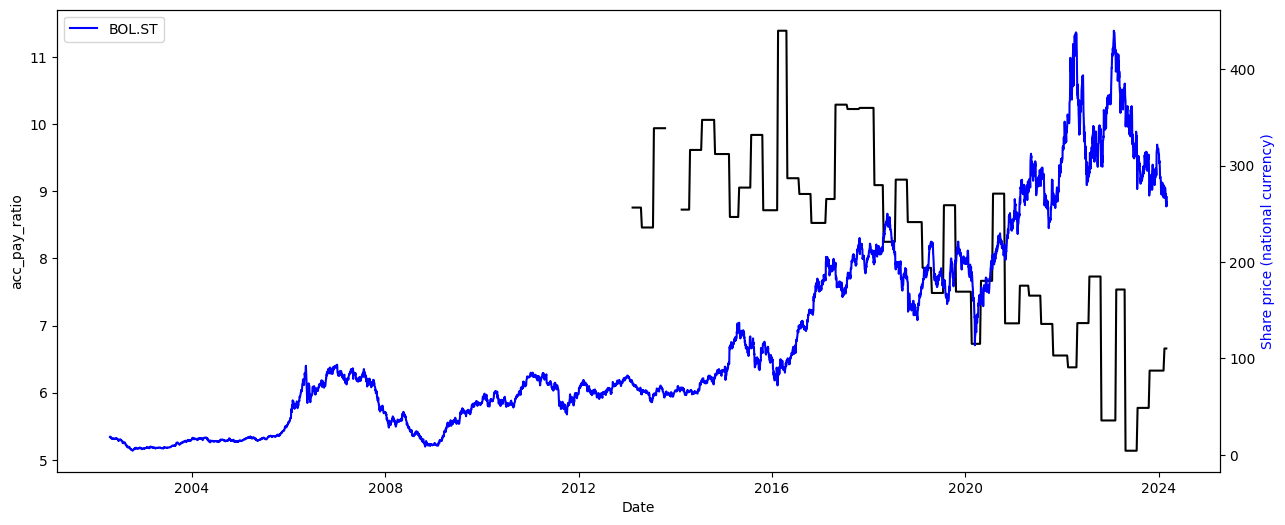

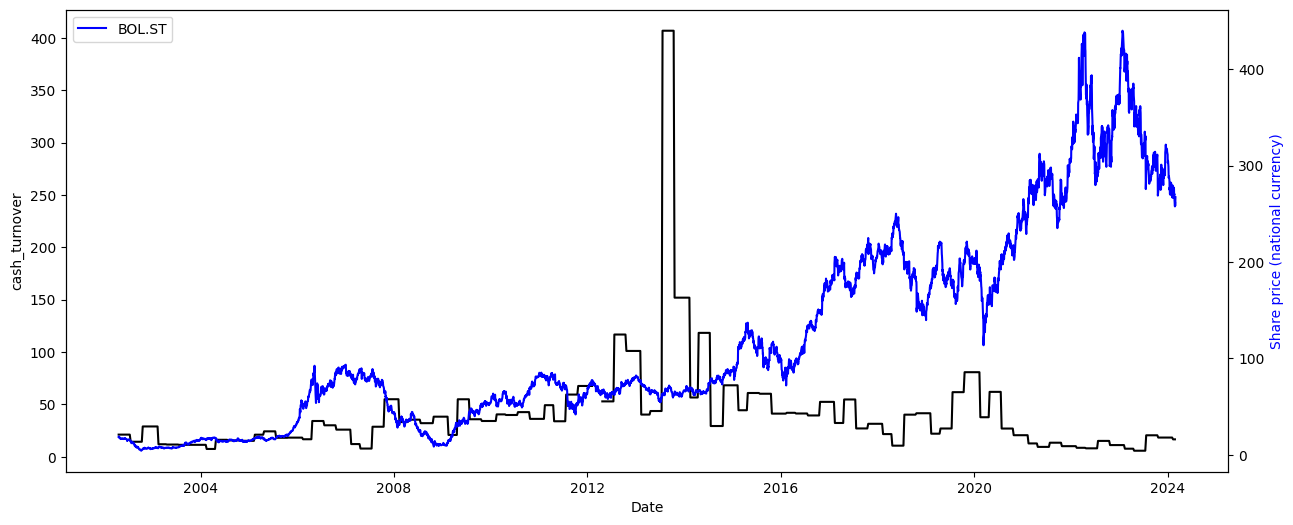

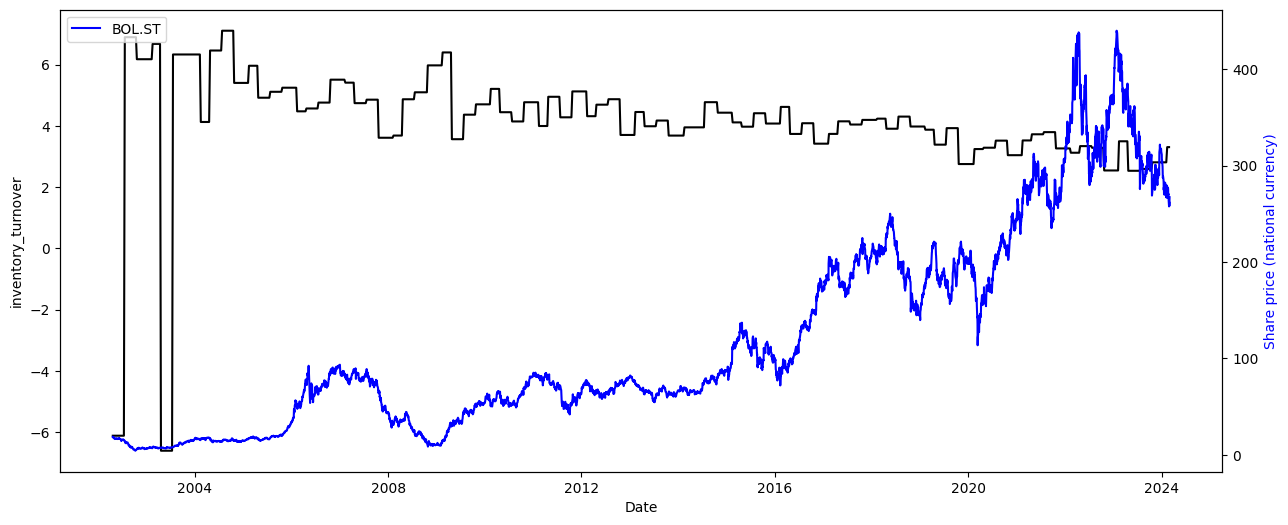

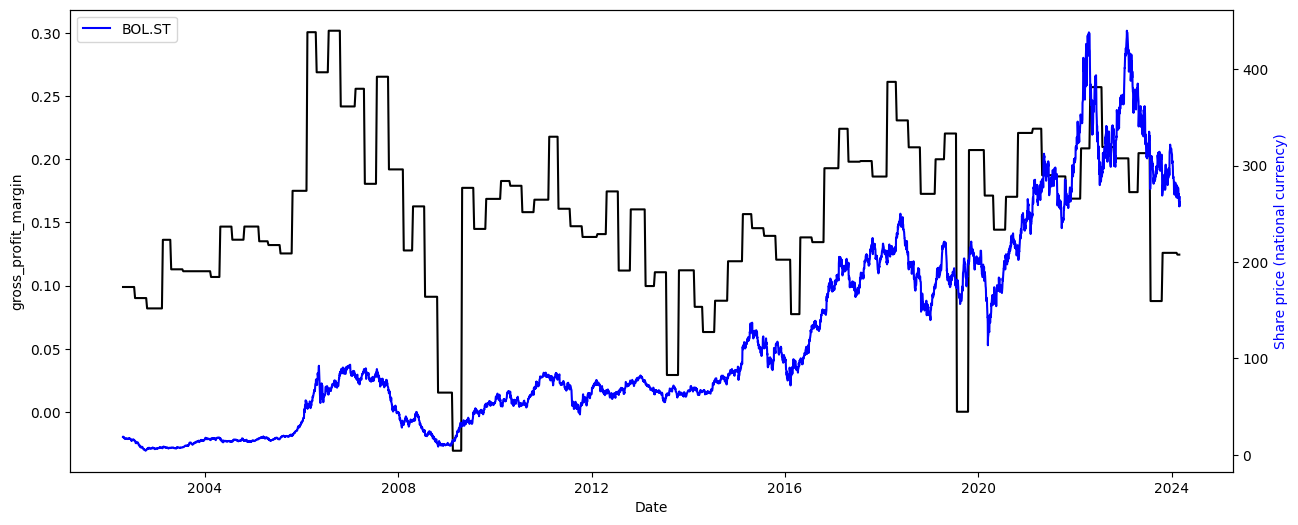

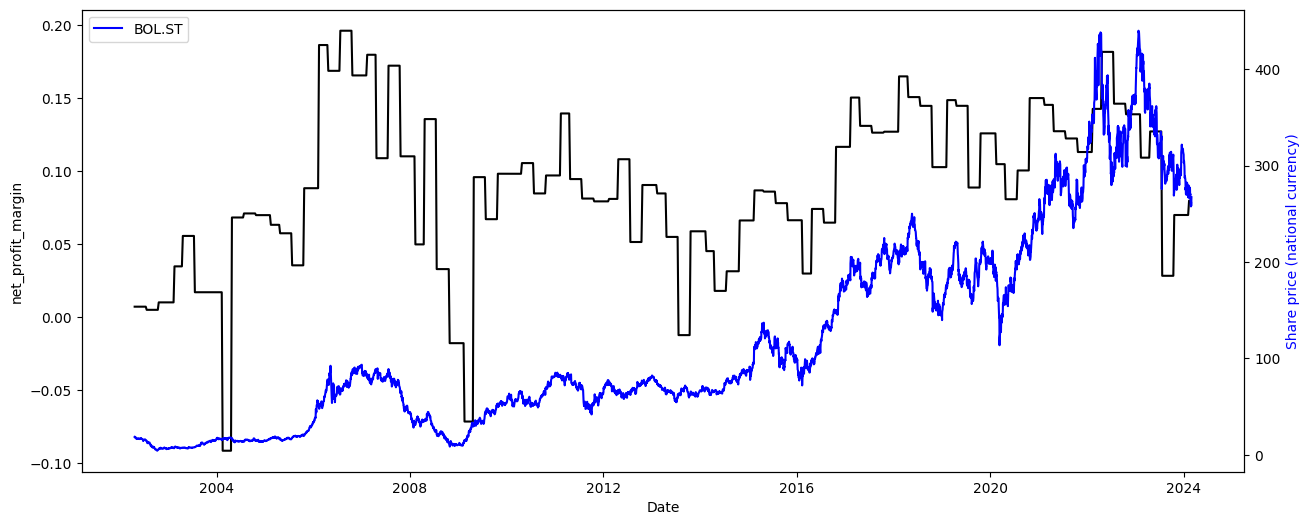

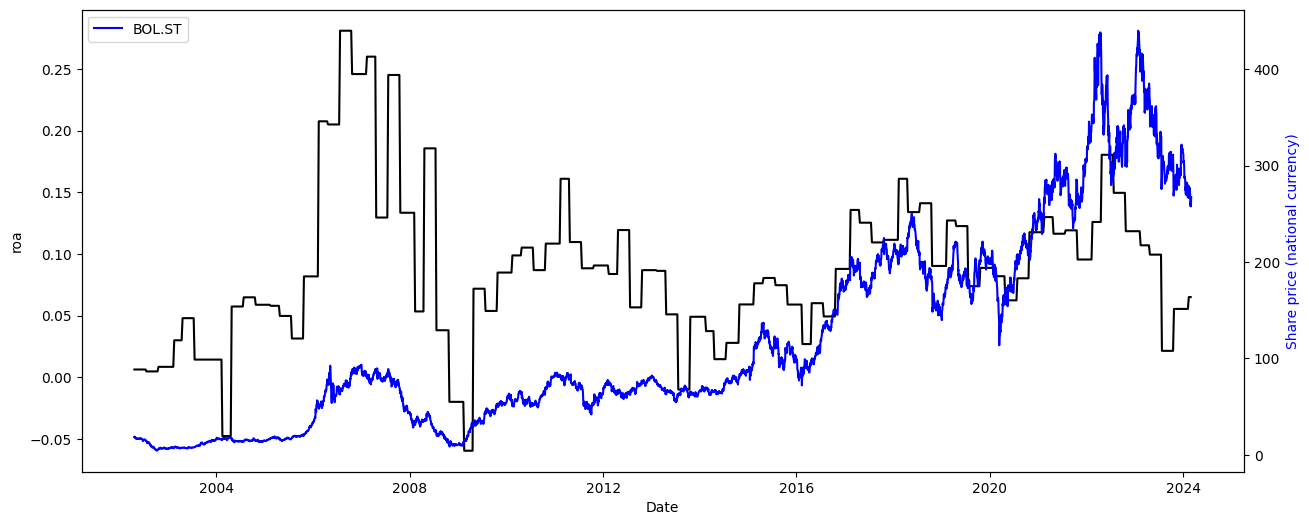

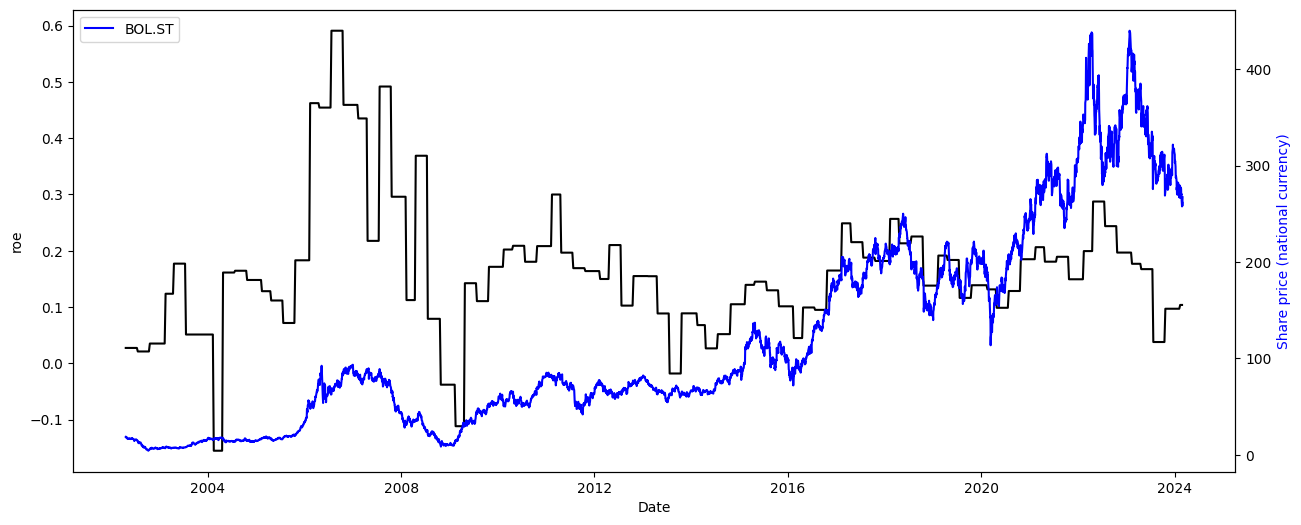

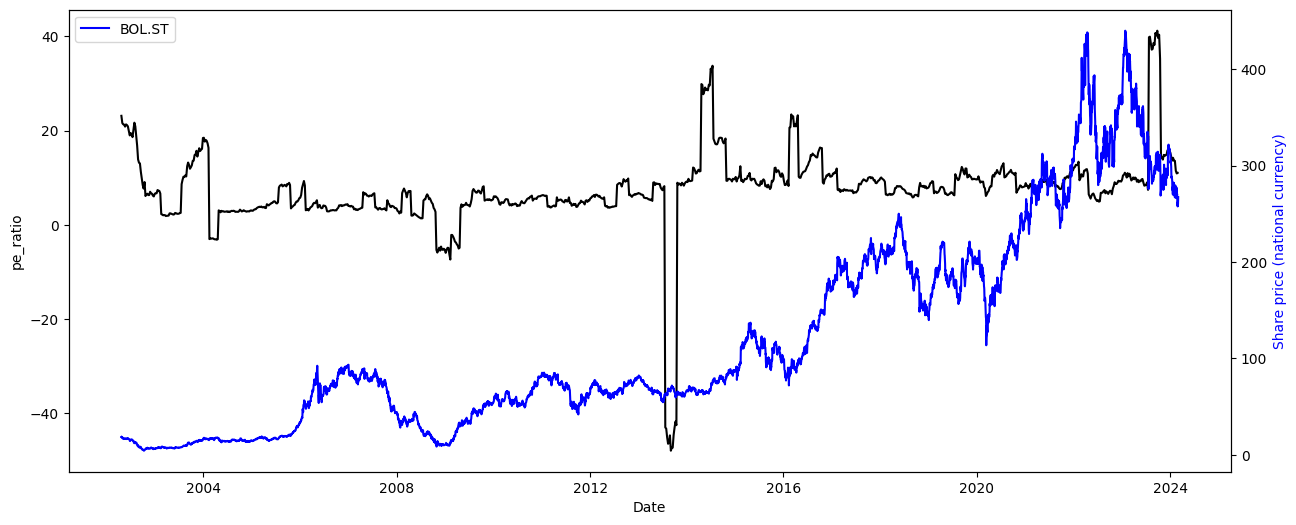

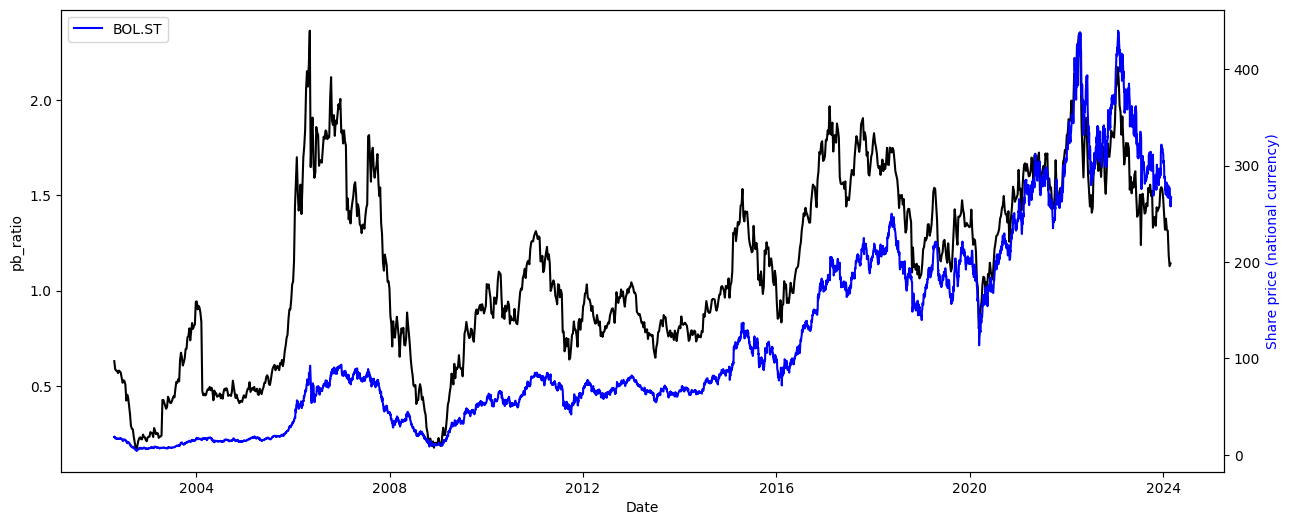

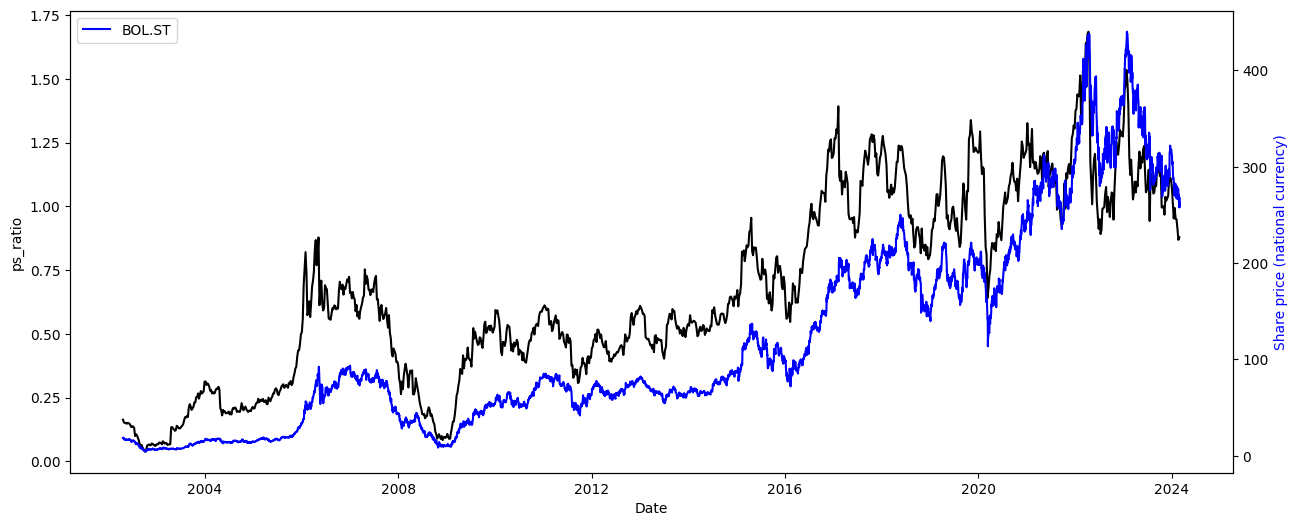

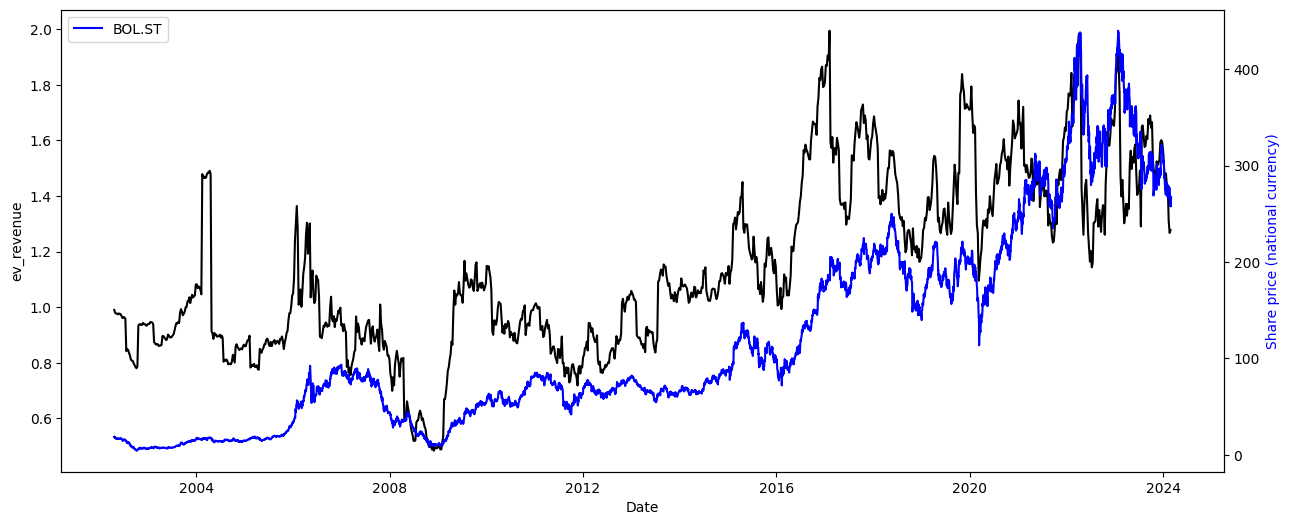

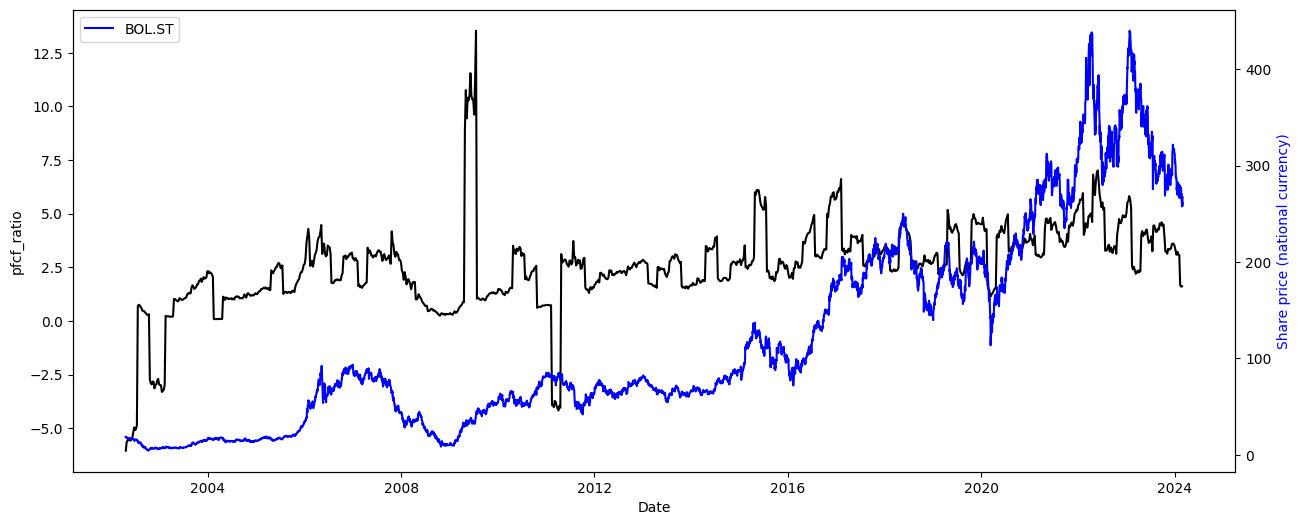

In [17]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

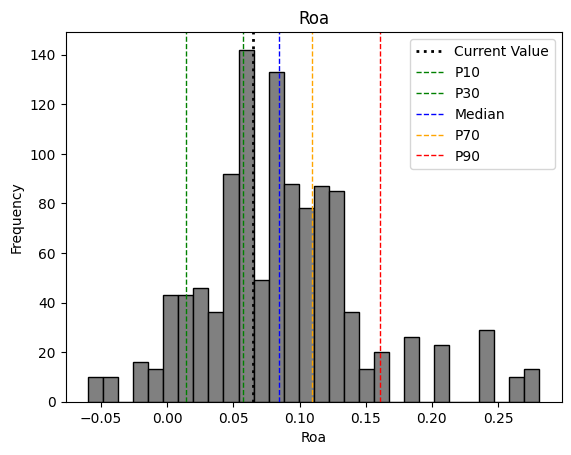

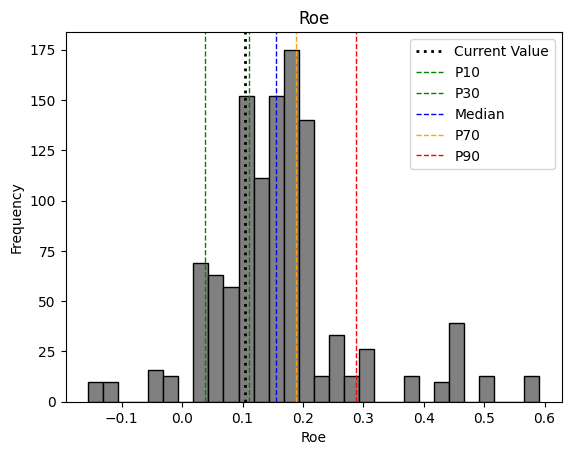

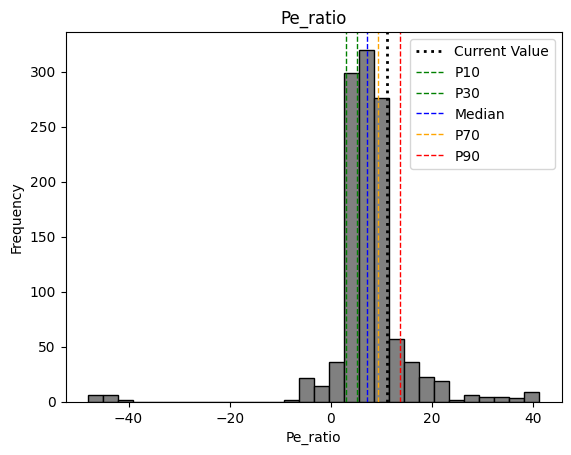

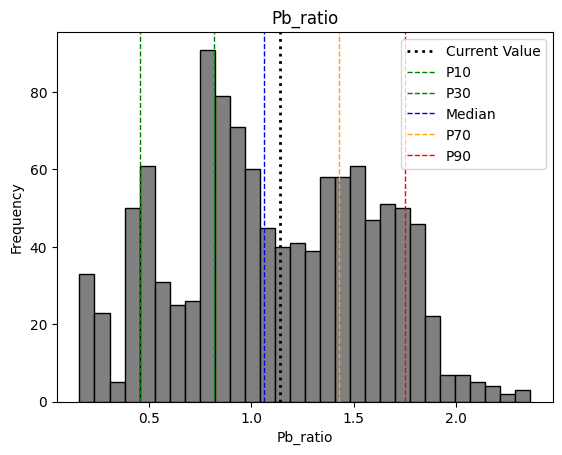

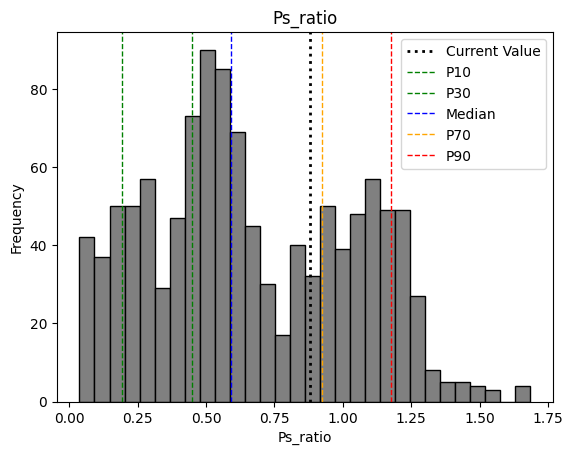

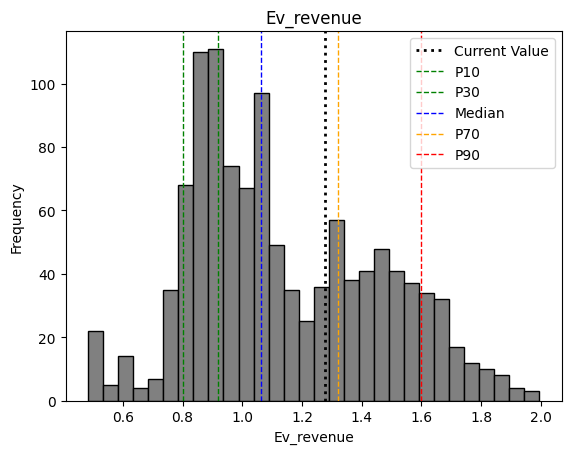

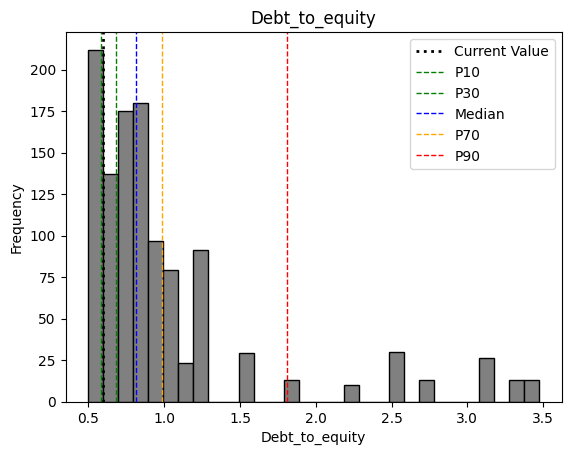

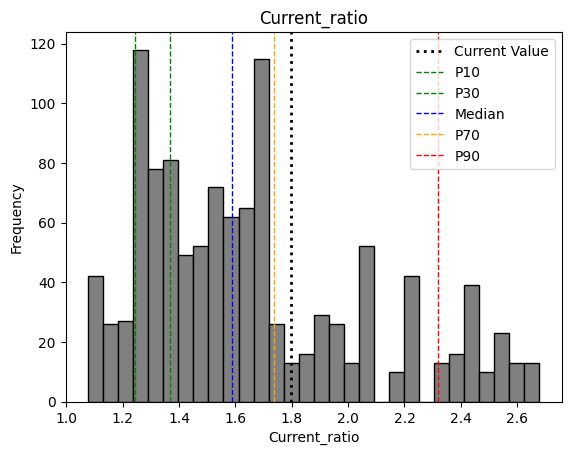

In [18]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[])

## Calculate correlation between value parameters

In [19]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.969116,-0.076607,0.676185,0.381309,0.115004,-0.388394,0.138924
roe,0.969116,1.000000,-0.105379,0.565496,0.220194,-0.016802,-0.243378,0.034044
pe_ratio,-0.076607,-0.105379,1.000000,0.190955,0.253627,0.307382,0.018051,0.026288
pb_ratio,0.676185,0.565496,0.190955,1.000000,0.881491,0.724519,-0.564499,0.287963
ps_ratio,0.381309,0.220194,0.253627,0.881491,1.000000,0.907417,-0.646671,0.421458
ev_revenue,0.115004,-0.016802,0.307382,0.724519,0.907417,1.000000,-0.363355,0.347152
debt_to_equity,-0.388394,-0.243378,0.018051,-0.564499,-0.646671,-0.363355,1.000000,-0.256147
current_ratio,0.138924,0.034044,0.026288,0.287963,0.421458,0.347152,-0.256147,1.000000


29 timestemos have been found!


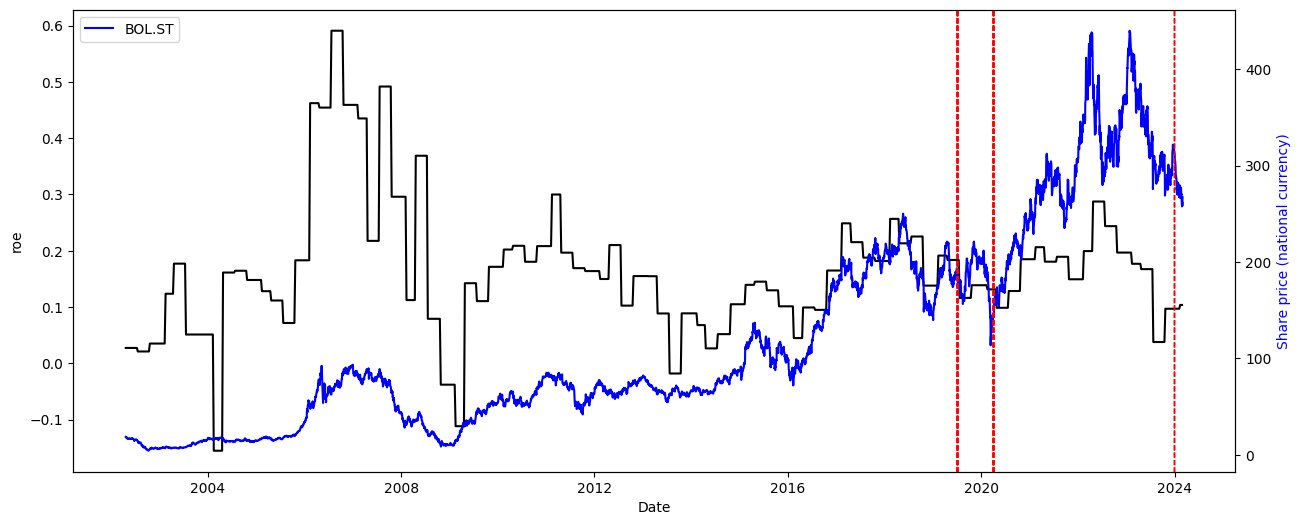

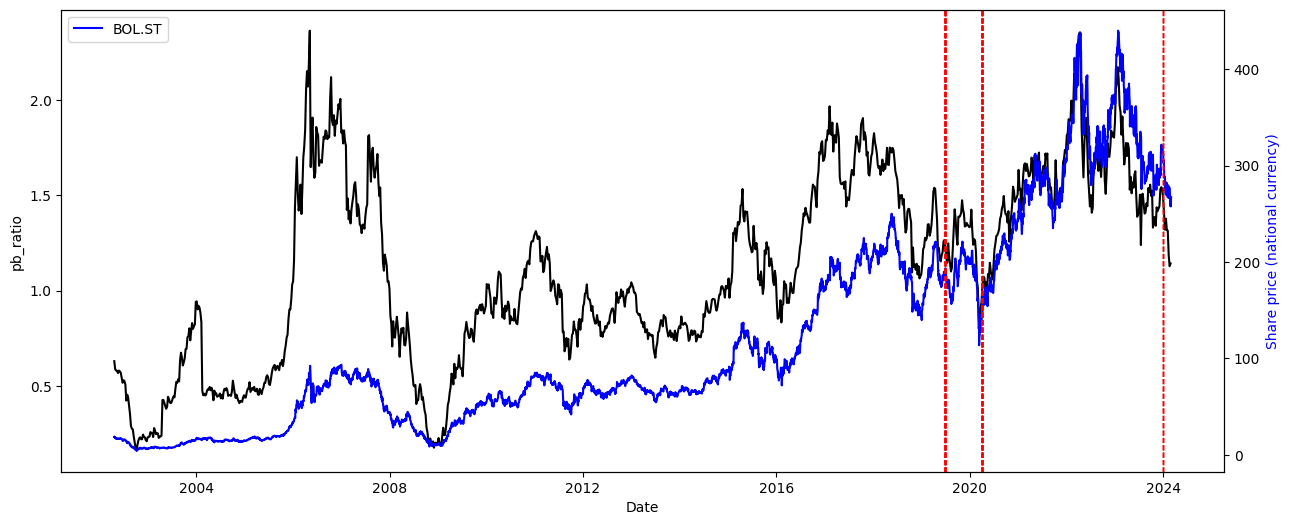

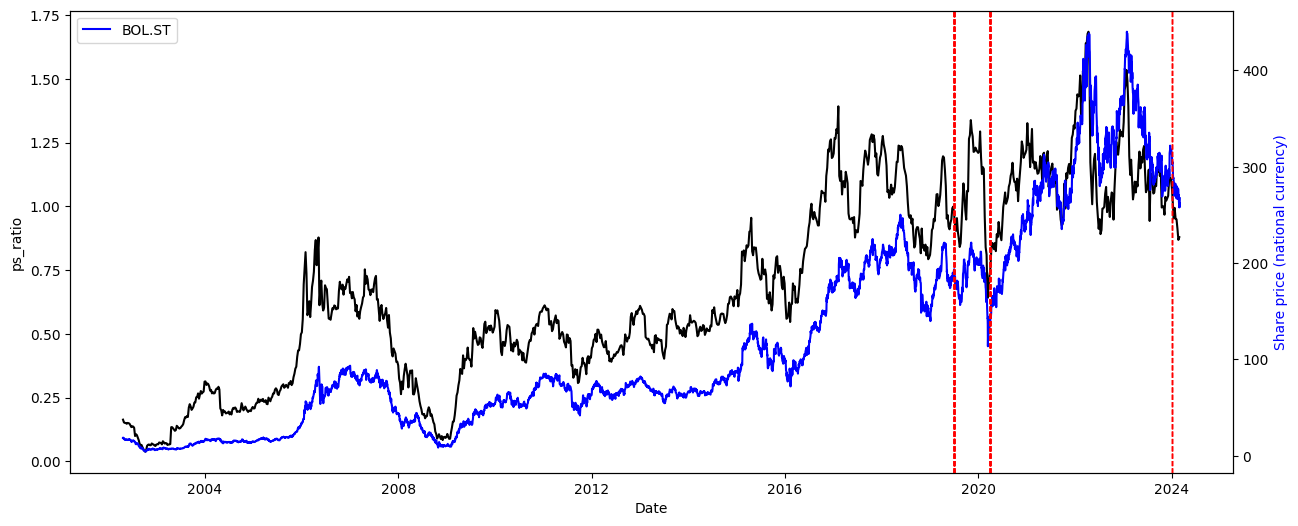

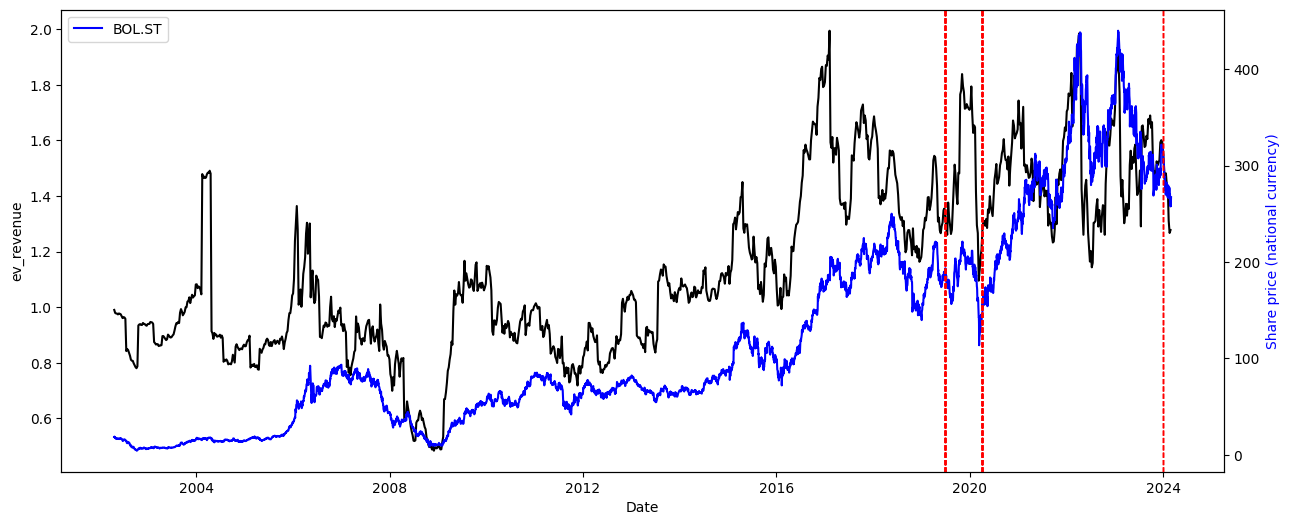

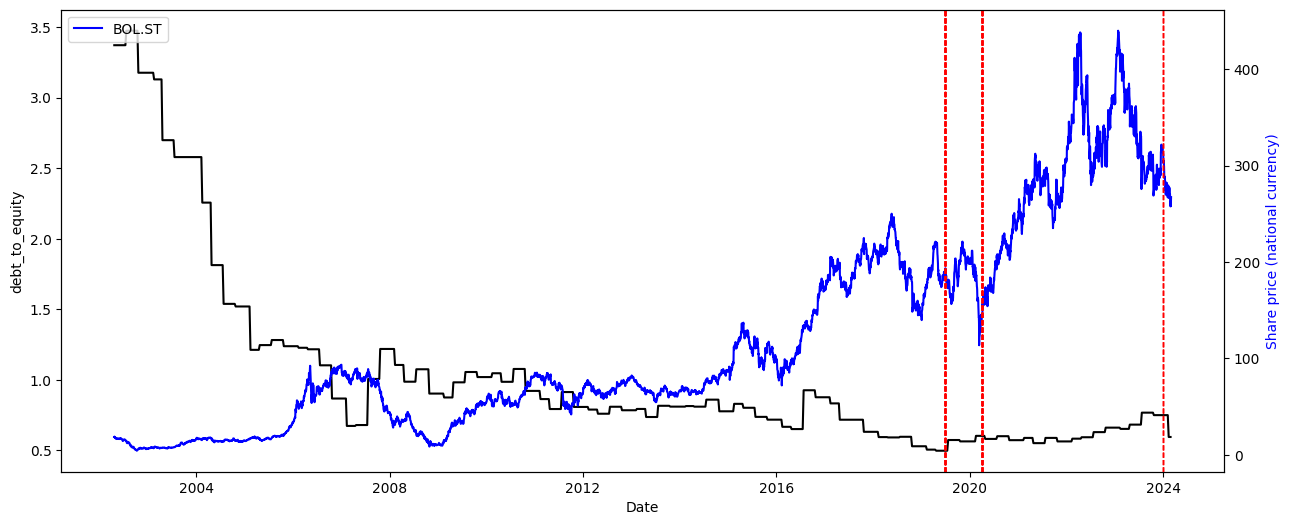

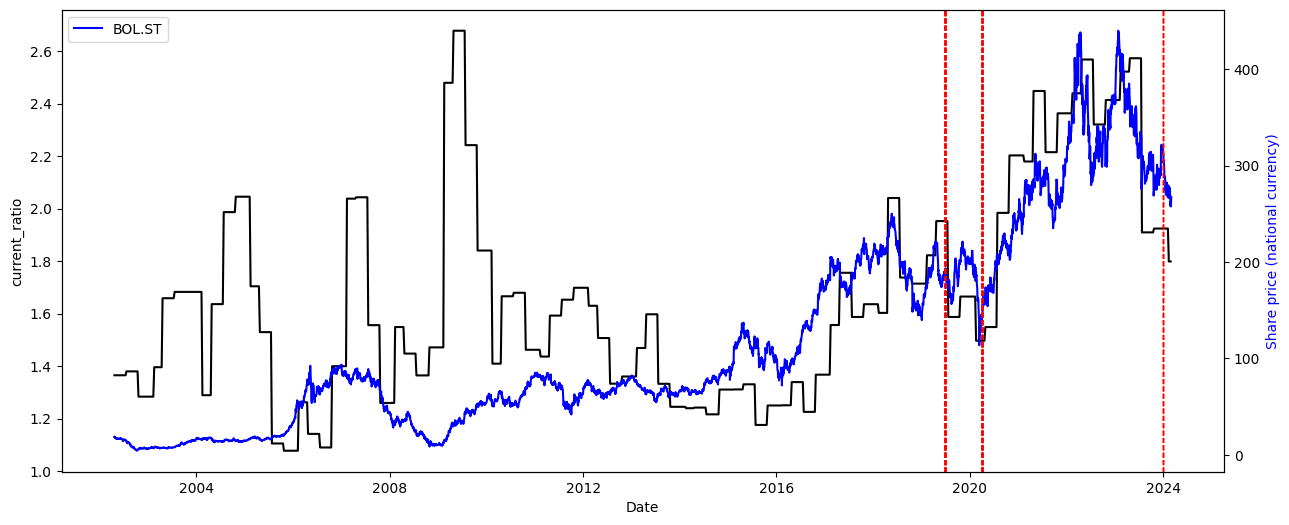

In [20]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2
    )